# On device Training

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 64

## Model Setup

In [18]:
BATCH_SIZE = 64
DIGIT_CLASSES = 10
MODEL_PATH = 'emnist_model.keras'

model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,264 (676.82 KB)

 Trainable params: 57,754 (225.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 115,510 (451.21 KB)

## Dataset Setup

In [19]:
(ds_train_digits, ds_test_digits), _ = tfds.load(
    'emnist/digits',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

def preprocess_digits(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train_digits = ds_train_digits.map(preprocess_digits).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test_digits = ds_test_digits.map(preprocess_digits).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Pre-training Evaluation

In [20]:
initial_loss, initial_acc = model.evaluate(ds_test_digits, verbose=0)
print(f"[BASELINE] Accuracy before training: {initial_acc:.4f}")

[BASELINE] Accuracy before training: 0.0300


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 


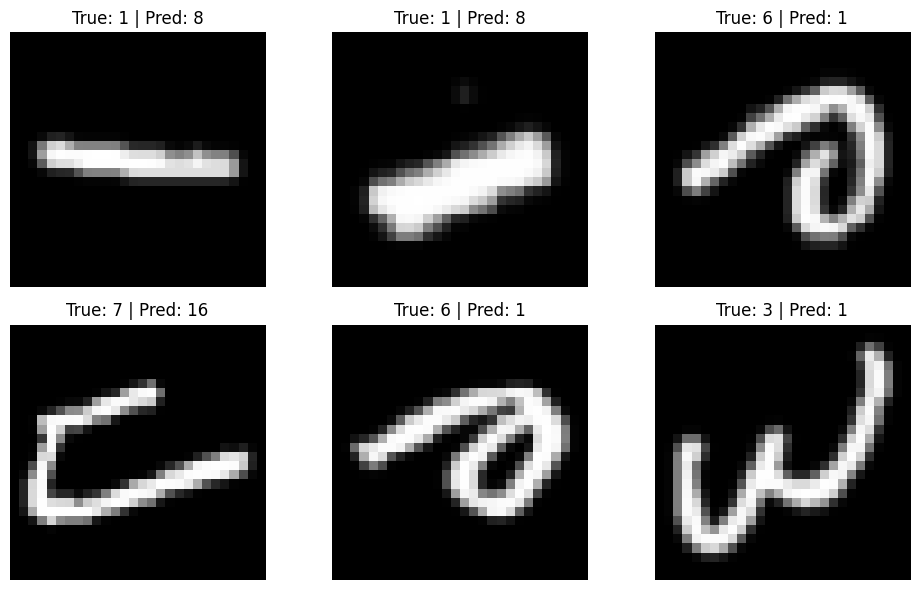

In [6]:
images, labels = next(iter(ds_test_digits))
preds_before = model.predict(images)
predicted_classes_before = np.argmax(preds_before, axis=1)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(tf.squeeze(images[i]), cmap='gray')
    plt.title(f"True: {labels[i].numpy()} | Pred: {predicted_classes_before[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## "On-Device" Training

In [21]:
all_train_digits = list(ds_train_digits.unbatch().take(500))
batch_size = 100
num_iterations = len(all_train_digits) // batch_size

accuracies = [initial_acc]
losses = [initial_loss]
image_counts = [0]

for i in range(num_iterations):
    batch_data = all_train_digits[i * batch_size : (i + 1) * batch_size]
    images = tf.stack([img for img, _ in batch_data])
    labels = tf.stack([lbl for _, lbl in batch_data])

    print(f"[INFO] Iteration {i+1} — Training with {len(images)} images")
    model.fit(images, labels, epochs=1, verbose=0)

    loss, acc = model.evaluate(ds_test_digits, verbose=0)
    print(f"[RESULT] Accuracy after {(i + 1) * batch_size} images: {acc:.4f}")
    accuracies.append(acc)
    losses.append(loss)
    image_counts.append((i + 1) * batch_size)


[INFO] Iteration 1 — Training with 100 images
[RESULT] Accuracy after 100 images: 0.1584
[INFO] Iteration 2 — Training with 100 images
[RESULT] Accuracy after 200 images: 0.2774
[INFO] Iteration 3 — Training with 100 images
[RESULT] Accuracy after 300 images: 0.4505
[INFO] Iteration 4 — Training with 100 images
[RESULT] Accuracy after 400 images: 0.5683
[INFO] Iteration 5 — Training with 100 images
[RESULT] Accuracy after 500 images: 0.6513


## Evaluation

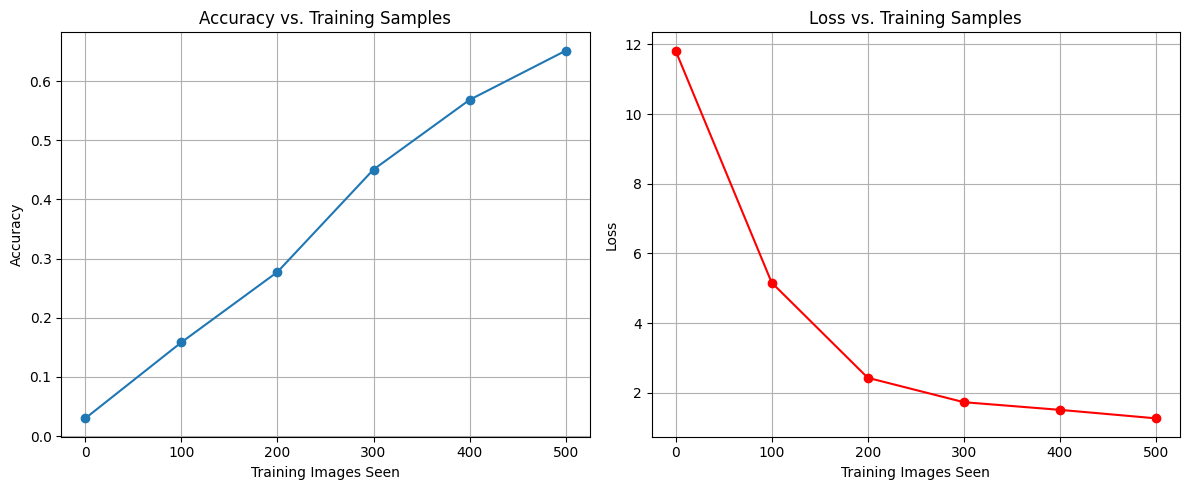

In [22]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(image_counts, accuracies, marker='o')
plt.title("Accuracy vs. Training Samples")
plt.xlabel("Training Images Seen")
plt.ylabel("Accuracy")
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(image_counts, losses, marker='o', color='red')
plt.title("Loss vs. Training Samples")
plt.xlabel("Training Images Seen")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


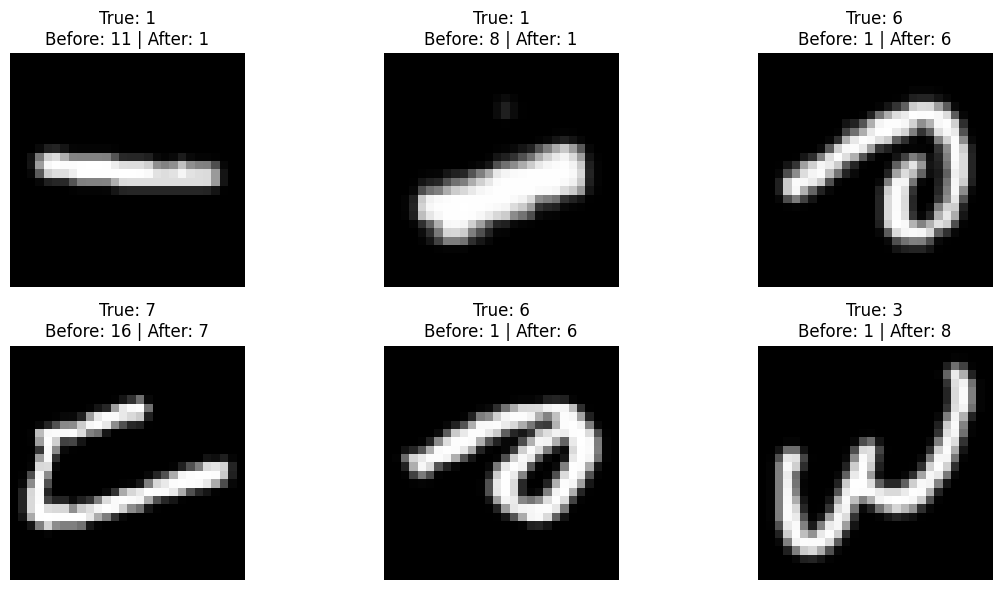

In [23]:
images, labels = next(iter(ds_test_digits))
images = images[:6]
labels = labels[:6]

model_pretrained = tf.keras.models.load_model('emnist_model.keras')
preds_before = model_pretrained.predict(images)
predicted_classes_before = np.argmax(preds_before, axis=1)

preds_after = model.predict(images)
predicted_classes_after = np.argmax(preds_after, axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(tf.squeeze(images[i]), cmap='gray')
    plt.title(
        f"True: {labels[i].numpy()}\n"
        f"Before: {predicted_classes_before[i]} | After: {predicted_classes_after[i]}"
    )
    plt.axis('off')
plt.tight_layout()
plt.show()


## OPTIONAL: SAVE NEW MODEL

In [24]:
model.save("emnist_letters_retrained_digits.keras")